In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import time
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
import wandb

# local modules
from utils import get_similarity_func,get_metrics_v1,get_metrics_v2,read_flow

In [ ]:
gt_img_path = "/home/mimo/Desktop/MS CV/C6/week_3/data/training/flow_occ/000045_10.png"
data_dir = "./data/training/image_0/"
all_files = glob(data_dir + "000045*.png")
assert len(all_files) > 0, "No files found in the directory"

# sort the files
all_files.sort()

In [ ]:
# Read the two images
img1 = cv2.imread(all_files[0], 0)
img2 = cv2.imread(all_files[1], 0)

# plot the images
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(img1, cmap="gray")
plt.axis("off")

plt.title("Image 1")
plt.subplot(122)
plt.imshow(img2, cmap="gray")
plt.title("Image 2")
plt.axis("off")
plt.show()

In [ ]:
def exhaustive_search():
    return

In [ ]:
import numpy as np


def exhaustive_search(
    prev_frame, next_frame, block_size=5, search_range=15, step_size=1,similarity_method="SAD"
):
    height, width = prev_frame.shape
    flow = np.zeros((height, width, 2), dtype=np.float32)

    similarity_func = get_similarity_func(similarity_method)

    half_block = block_size // 2
    half_search = search_range // 2

    for y in range(half_search, height - half_search, step_size):
        for x in range(half_search, width - half_search, step_size):
            prev_block = prev_frame[
                y - half_block : y + half_block + 1, x - half_block : x + half_block + 1
            ]

            min_diff = float("inf")
            best_offset = [0, 0]

            for dy in range(-half_search, half_search + 1):
                for dx in range(-half_search, half_search + 1):
                    next_x = x + dx
                    next_y = y + dy

                    if (
                        next_x - half_block < 0
                        or next_x + half_block >= width
                        or next_y - half_block < 0
                        or next_y + half_block >= height
                    ):
                        continue

                    next_block = next_frame[
                        next_y - half_block : next_y + half_block + 1,
                        next_x - half_block : next_x + half_block + 1,
                    ]

                    # diff = np.sum(np.abs(prev_block - next_block))
                    diff = similarity_func(prev_block, next_block)
                    if diff < min_diff:
                        min_diff = diff

                        print(dx, dy)
                        best_offset = [dx, dy]

            flow[y, x] = best_offset

    return flow


def three_step_search(
    prev_frame, next_frame, block_size=5, search_range=15, step_size=1,similarity_method="SAD"
):
    height, width = prev_frame.shape
    flow = np.zeros((height, width, 2), dtype=np.float32)

    similarity_func = get_similarity_func(similarity_method)

    half_block = block_size // 2
    half_search = search_range // 2

    for y in range(half_block, height - half_block, block_size):
        for x in range(half_block, width - half_block, block_size):
            min_diff = float("inf")
            best_offset = [0, 0]

            for step in [half_search, half_search // 2, half_search // 4]:
                for dy in range(-step, step + 1, step):
                    for dx in range(-step, step + 1, step):
                        next_x = x + dx
                        next_y = y + dy

                        if (
                            next_x - half_block < 0
                            or next_x + half_block >= width
                            or next_y - half_block < 0
                            or next_y + half_block >= height
                        ):
                            continue

                        prev_block = prev_frame[
                            y - half_block : y + half_block + 1,
                            x - half_block : x + half_block + 1,
                        ]

                        next_block = next_frame[
                            next_y - half_block : next_y + half_block + 1,
                            next_x - half_block : next_x + half_block + 1,
                        ]

                        # diff = np.sum(np.abs(prev_block - next_block))
                        diff = similarity_func(prev_block, next_block)
                        if diff < min_diff:
                            min_diff = diff
                            best_offset = [dx, dy]

            flow[y, x] = best_offset

    return flow


def block_matching(
    prev_frame,
    next_frame,
    block_size=5,
    search_range=15,
    step_size=1,
    method="three_step",
    similarity_method="SAD",
):
    if method == "exhaustive":
        return exhaustive_search(
            prev_frame,
            next_frame,
            block_size,
            search_range,
            step_size,
            similarity_method,
        )
    elif method == "three_step":
        return three_step_search(
            prev_frame,
            next_frame,
            block_size,
            search_range,
            step_size,
            similarity_method,
        )

In [ ]:
# available set of values for tuning
available_block_size = [8, 16, 32, 64, 128, 256, 512, 1024]
available_search_range = [150, 200, 250, 300, 350, 400, 450, 500]
available_step_size = [8, 16, 32, 64]
available_similarity_methods = ["SAD", "SSD", "NCC", "MSE", "SSIM", "HAMMING"]

available_methods = [ "three_step"]

# ground truth flow
gt_flow = read_flow(gt_img_path)

def objective(trail):
    wandb.init(project="block_matching_optuna", config=trail.params)

    # define the hyperparameters
    block_size = trail.suggest_categorical("block_size", available_block_size)
    search_range = trail.suggest_categorical("search_range", available_search_range)
    step_size = trail.suggest_categorical("step_size", available_step_size)
    similarity_method = trail.suggest_categorical(
        "similarity_method", available_similarity_methods
    )
    method = trail.suggest_categorical("method", available_methods)

    start_time = time.time()
    predicted_flow = block_matching(
        img1, img2, block_size=block_size, search_range=search_range, step_size=step_size, method=method,similarity_method=similarity_method
    )
    end_time = time.time()
    
    total_time = end_time - start_time

    # get the metrics
    msen, pepn = get_metrics_v2(predicted_flow, gt_flow)
    
    MSEN, PEPN = get_metrics_v1(predicted_flow, gt_flow)
    
    # wandb log 
    wandb.log({
        "MSEN_v2": msen,
        "PEPN_v2": pepn,
        "MSEN_v1": MSEN,
        "PEPN_v1": PEPN,
        "total_time": total_time,
        "block_size": block_size,
        "search_range": search_range,
        "step_size": step_size,
        "similarity_method": similarity_method,
        "method": method
    })
    
    
    
    return msen

In [ ]:
wandb_kwargs = {"project": "FINDING_BEST_COMBINATION_GUNJAN"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)
if __name__ == "__main__":
    study = optuna.create_study(
        direction="maximize",
        storage="sqlite:///db.sqlite3",
        pruner=optuna.pruners.SuccessiveHalvingPruner(),
    )
    study.optimize(
        objective,
        n_trials=1000000000000000000,
        timeout=600000000000000000,
        callbacks=[wandbc],  # weight and bias connection
    )

In [1]:
import wandb
import pandas as pd

# Initialize the wandb API
api = wandb.Api()

# Define the entity (username or team name) and project name
entity = "c5"
project = "block_matching_optuna"

# Get all runs in the specified project
runs = api.runs(f"{entity}/{project}")

# Initialize an empty DataFrame to store all metrics
all_metrics = pd.DataFrame()

# Iterate over all runs
for run in runs:
    # Retrieve the metrics for each run
    metrics_dataframe = run.history()

    # Add a column to identify the run
    metrics_dataframe["run_id"] = run.id

    # Concatenate the metrics for this run with the overall metrics DataFrame
    all_metrics = pd.concat([all_metrics, metrics_dataframe])

# Save all metrics to a CSV file
all_metrics.to_csv("all_metrics.csv", index=False)

In [11]:
"""




"""

# mean of abouve columns 
mean_msne_v2 = all_metrics["MSEN_v2"].mean()
mean_pepn_v2 = all_metrics["PEPN_v2"].mean()
mean_total_time = all_metrics["total_time"].mean()
mean_pepn_v1 = all_metrics["PEPN_v1"].mean()
mean_msne_v1 = all_metrics["MSEN_v1"].mean()
mean_time = all_metrics["total_time"].mean()

print(f"mean_msne_v2: {mean_msne_v2}")
print(f"mean_pepn_v2: {mean_pepn_v2}")
print(f"mean_total_time: {mean_total_time}")
print(f"mean_pepn_v1: {mean_pepn_v1}")
print(f"mean_msne_v1: {mean_msne_v1}")
print(f"mean_time: {mean_time}")


mean_msne_v2: 12.610353774255534
mean_pepn_v2: 0.1978717013484475
mean_total_time: 3.8250865993385545
mean_pepn_v1: 0.8027958746957432
mean_msne_v1: 12.480073518253372
mean_time: 3.8250865993385545


In [9]:
all_metrics.columns

Index(['run_id', 'MSEN_v2', 'PEPN_v2', '_step', 'total_time', 'trial_number',
       '_runtime', '_timestamp', 'value', 'PEPN_v1', 'step_size', 'block_size',
       'search_range', 'similarity_method', 'method', 'MSEN_v1'],
      dtype='object')

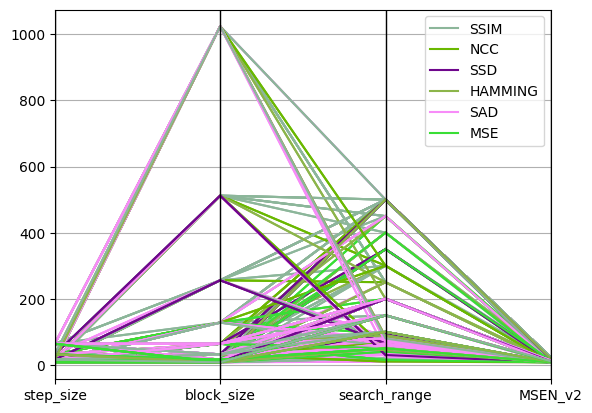

In [10]:
import pandas as pd
from pandas.plotting import parallel_coordinates

# Create a subset of the data with the desired columns
plot_data = all_metrics[['step_size', 'block_size', 'search_range', 'similarity_method', 'MSEN_v2']]

# Plot the parallel coordinates
parallel_coordinates(plot_data, 'similarity_method')

# Display the plot
plt.show()
